In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# read the file

In [18]:
local_path = "../data/Txs_LoteriaBlacksmith.xlsx"
df = pd.read_excel(local_path)

# EDA

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99789 entries, 0 to 99788
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   IdCliente    99769 non-null  float64       
 1   Genero       99789 non-null  object        
 2   CodOficina   99789 non-null  int64         
 3   CodSDV       99789 non-null  int64         
 4   CodCanal     99789 non-null  int64         
 5   CodProducto  99789 non-null  object        
 6   NomProducto  99789 non-null  object        
 7   FechaTx      99789 non-null  datetime64[ns]
 8   HoraTx       99789 non-null  int64         
 9   Cantidad     99789 non-null  int64         
 10   Ingreso     99789 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 8.4+ MB


In [20]:
# Lista de nombres de columnas a convertir a categorías
columnas_a_convertir = ['IdCliente', 'CodOficina', 'CodSDV', 'CodCanal']

# Convertir las columnas a categorías
df[columnas_a_convertir] = df[columnas_a_convertir].astype('str')

In [21]:
# Filtrar las columnas numéricas
columnas_numericas = df.select_dtypes(include='number')
columnas_numericas.describe()

,HoraTx,Cantidad,Ingreso
count,99789.000000,99789.000000,99789.000000
mean,14.268577,2.541352,9763.130205
std,3.915750,2.724239,12231.076464
min,0.000000,1.000000,2000.000000
25%,11.000000,1.000000,3000.000000
50%,15.000000,2.000000,6000.000000
75%,17.000000,3.000000,12000.000000
max,23.000000,50.000000,285000.000000


In [22]:
# Filtrar las columnas categóricas
columnas_categoricas = df.select_dtypes(include='object')
columnas_categoricas.describe()

,IdCliente,Genero,CodOficina,CodSDV,CodCanal,CodProducto,NomProducto
count,99789,99789,99789,99789,99789,99789,99789
unique,24810,3,221,2508,5,1,1
top,166177.0,M,2936801,109216,1,P551,LOTERIA BLACKSMITH
freq,2738,50015,5886,2711,76353,99789,99789


In [23]:
df_sel = df.drop(['IdCliente','NomProducto','CodProducto'],axis=1)

## seleccionar los 25 codigos de sitios de venta que mas cantidades venden

In [24]:
df_sdv_top =df_sel.groupby(by='CodSDV', sort=True)['Cantidad'].sum().sort_values(ascending=False).head(25).reset_index()
df_sdv_top.head(5)
df_sdv_top.to_csv('top_cod_sdv.csv')

In [25]:
list_cod_sdv= list(df_sdv_top['CodSDV'].unique())
list_cod_sdv[0]

'109216'

In [26]:
df_by_sdv = df_sel[df_sel['CodSDV']==list_cod_sdv[0]]
columnas_agrupar = ['CodSDV','FechaTx']
columna_sumar = ['Cantidad']
df_by_sdv = df_by_sdv.groupby(by=columnas_agrupar)[columna_sumar].sum().reset_index()[['FechaTx','Cantidad']]
df_by_sdv

,FechaTx,Cantidad
0,2022-08-16,2
1,2022-08-17,1
2,2022-08-18,4
3,2022-08-19,1
4,2022-08-26,1
...,...,...
275,2023-07-10,14
276,2023-07-11,43
277,2023-07-12,17
278,2023-07-13,31


In [27]:
import holidays_co
# Convertir la columna "Fecha Tx" a tipo datetime si no lo está
df_by_sdv['FechaTx'] = pd.to_datetime(df_by_sdv['FechaTx'])


# Establecer la columna "Fecha Tx" como índice del DataFrame
df_by_sdv = df_by_sdv.set_index('FechaTx')


# Generar un rango de fechas desde la primera hasta la última fecha en el DataFrame
rango_fechas = pd.date_range(start=df_by_sdv.index.min(), end=df_by_sdv.index.max(), freq='D')

# Reindexar el DataFrame con el rango de fechas generado
df_by_sdv = df_by_sdv.reindex(rango_fechas, fill_value=0)

df_by_sdv = df_by_sdv.reset_index()

# Agregar la columna de día de la semana en formato numérico (Lunes = 0, Domingo = 6)
df_by_sdv['DiaSemana'] = df_by_sdv['index'].dt.weekday

# Agregar la columna de mes en formato numérico
df_by_sdv['Mes'] = df_by_sdv['index'].dt.month

# Agregar la columna de mes en formato numérico
df_by_sdv['Dia'] = df_by_sdv['index'].dt.day

# quincena
quincena =[15,30,31]
df_by_sdv['EsQuincena'] = df_by_sdv['Dia'].map(lambda x: x in quincena)

# Agregar la columna de festivo o día laboral
df_by_sdv['EsFestivo'] = df_by_sdv['index'].map(lambda x: holidays_co.is_holiday_date(x))

# Establecer la columna "Fecha Tx" como índice del DataFrame
df_by_sdv = df_by_sdv.set_index('index')

df_by_sdv['media_movil_4'] = df_by_sdv['Cantidad'].rolling(window=4).mean()

df_by_sdv['media_movil_7'] = df_by_sdv['Cantidad'].rolling(window=7).mean()

df_by_sdv['media_movil_14'] = df_by_sdv['Cantidad'].rolling(window=14).mean()

df_by_sdv['media_movil_21'] = df_by_sdv['Cantidad'].rolling(window=21).mean()

df_by_sdv['media_movil_30'] = df_by_sdv['Cantidad'].rolling(window=30).mean()


df_by_sdv.head(15)

,Cantidad,DiaSemana,Mes,Dia,EsQuincena,EsFestivo,media_movil_4,media_movil_7,media_movil_14,media_movil_21,media_movil_30
index,,,,,,,,,,,
2022-08-16,2,1,8,16,False,False,NaN,NaN,NaN,NaN,NaN
2022-08-17,1,2,8,17,False,False,NaN,NaN,NaN,NaN,NaN
2022-08-18,4,3,8,18,False,False,NaN,NaN,NaN,NaN,NaN
2022-08-19,1,4,8,19,False,False,2.00,NaN,NaN,NaN,NaN
2022-08-20,0,5,8,20,False,False,1.50,NaN,NaN,NaN,NaN
2022-08-21,0,6,8,21,False,False,1.25,NaN,NaN,NaN,NaN
2022-08-22,0,0,8,22,False,False,0.25,1.142857,NaN,NaN,NaN
2022-08-23,0,1,8,23,False,False,0.00,0.857143,NaN,NaN,NaN
2022-08-24,0,2,8,24,False,False,0.00,0.714286,NaN,NaN,NaN


In [29]:
df_by_sdv['media_movil_4'] = df_by_sdv['media_movil_4'].shift(1)

df_by_sdv['media_movil_7'] = df_by_sdv['media_movil_7'].shift(1)

df_by_sdv['media_movil_14'] = df_by_sdv['media_movil_14'].shift(1) 

df_by_sdv['media_movil_21'] = df_by_sdv['media_movil_21'].shift(1)

df_by_sdv['media_movil_30'] = df_by_sdv['media_movil_30'].shift(1)
df_by_sdv.head(15)

,Cantidad,DiaSemana,Mes,Dia,EsQuincena,EsFestivo,media_movil_4,media_movil_7,media_movil_14,media_movil_21,media_movil_30
index,,,,,,,,,,,
2022-08-16,2,1,8,16,False,False,NaN,NaN,NaN,NaN,NaN
2022-08-17,1,2,8,17,False,False,NaN,NaN,NaN,NaN,NaN
2022-08-18,4,3,8,18,False,False,NaN,NaN,NaN,NaN,NaN
2022-08-19,1,4,8,19,False,False,NaN,NaN,NaN,NaN,NaN
2022-08-20,0,5,8,20,False,False,2.00,NaN,NaN,NaN,NaN
2022-08-21,0,6,8,21,False,False,1.50,NaN,NaN,NaN,NaN
2022-08-22,0,0,8,22,False,False,1.25,NaN,NaN,NaN,NaN
2022-08-23,0,1,8,23,False,False,0.25,1.142857,NaN,NaN,NaN
2022-08-24,0,2,8,24,False,False,0.00,0.857143,NaN,NaN,NaN


<Axes: xlabel='index'>

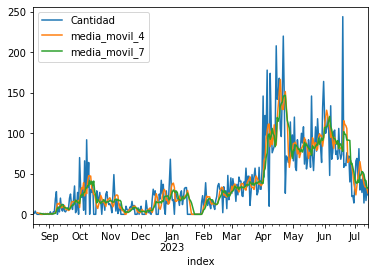

In [31]:
df_by_sdv[['Cantidad','media_movil_4','media_movil_7']].plot()

In [32]:
data_sel = df_by_sdv.columns[:]
data = df_by_sdv[data_sel]
data = data.asfreq('d')
data = data.sort_index()
data.tail(15)

,Cantidad,DiaSemana,Mes,Dia,EsQuincena,EsFestivo,media_movil_4,media_movil_7,media_movil_14,media_movil_21,media_movil_30
index,,,,,,,,,,,
2023-06-30,14,4,6,30,True,False,37.75,52.142857,71.928571,76.904762,85.966667
2023-07-01,37,5,7,1,False,False,31.25,43.285714,67.500000,73.952381,80.966667
2023-07-02,66,6,7,2,False,False,24.00,39.142857,65.285714,70.857143,78.266667
2023-07-03,69,0,7,3,False,True,35.00,38.285714,64.714286,69.047619,77.133333
2023-07-04,44,1,7,4,False,False,46.50,42.428571,52.214286,68.809524,75.900000
2023-07-05,81,2,7,5,False,False,54.00,39.285714,51.214286,67.190476,73.366667
2023-07-06,30,3,7,6,False,False,65.00,47.714286,52.571429,67.809524,72.533333
2023-07-07,43,4,7,7,False,False,56.00,48.714286,50.428571,64.190476,71.933333
2023-07-08,27,5,7,8,False,False,49.50,52.857143,48.071429,62.619048,68.900000


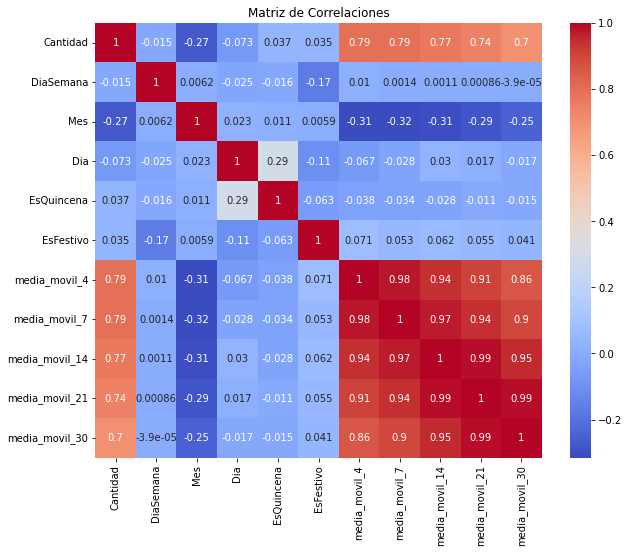

In [33]:
# Supongamos que tienes un DataFrame llamado 'df' con las variables a analizar

# Calcular la matriz de correlaciones
correlation_matrix = data.corr() #pearson

# Crear el mapa de calor de la matriz de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Configurar el título del gráfico
plt.title("Matriz de Correlaciones")

# Mostrar el gráfico
plt.show()

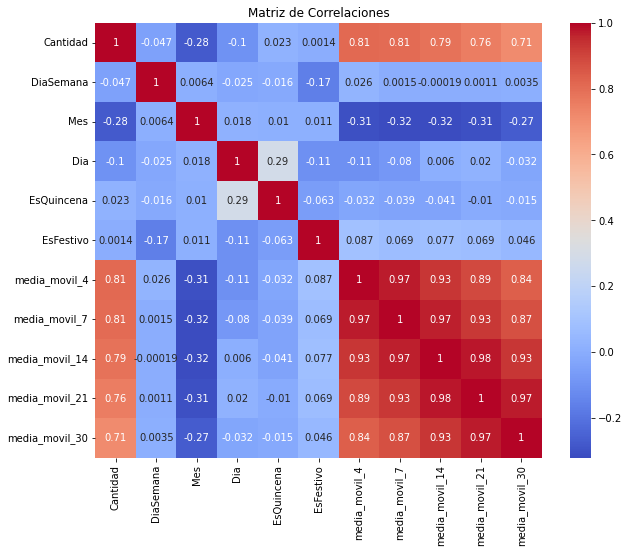

In [34]:
# Supongamos que tienes un DataFrame llamado 'df' con las variables a analizar

# Calcular la matriz de correlaciones
correlation_matrix = data.corr(method='spearman')

# Crear el mapa de calor de la matriz de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Configurar el título del gráfico
plt.title("Matriz de Correlaciones")

# Mostrar el gráfico
plt.show()

In [36]:

# Libraries
# ==============================================================================

from model.nn_regresor import MlpRegressorModel
from model.xgboost_regressor import XgboostRegressorModel
from model.lasso import LassoModel
from model.auxiliar_functions import evaluate_metrics,select_best_model,obtain_steps,series_to_supervised

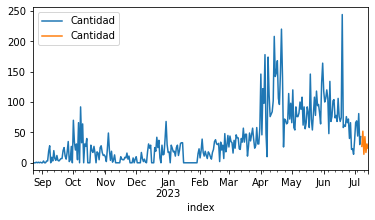

In [18]:
# Split train-test
# ==============================================================================
y = 'Cantidad'
steps = 7
sel_exog = ['Mes', 'Dia','media_movil']#, 'DiaSemana','EsQuincena', 'EsFestivo']
data_train = data[:-steps].dropna()
data_test  = data[-steps:]
# Lags used as predictors
lags_grid = [7, 21, 60]#[7, 14, 21, 30, 60]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train[[y]].plot(ax=ax, label='train')
data_test[[y]].plot(ax=ax, label='test')
ax.legend()

In [19]:

# Prediction error
# ==============================================================================

mse = mean_squared_error(
                y_true = data_test[y],
                y_pred = data_test['media_movil']
            )
mape = mean_absolute_percentage_error(
                y_true = data_test[y],
                y_pred = data_test['media_movil']
            )
r2 = r2_score(
                y_true = data_test[y],
                y_pred = data_test['media_movil']
            )
            
print(f"Test error (mse): {mse} mape: {mape} r2: {r2}")

Test error (mse): 370.798833819242 mape: 0.7660193893436252 r2: -1.3104199970934456


In [20]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer# Create and fit forecaster with different transformer for each exog variable
# ==============================================================================
transformer_exog = ColumnTransformer(
                       [#('scale_1', OneHotEncoder(), ['DiaSemana']),
                        ('scale_2', MinMaxScaler(), ['Mes']),
                        ('scale_3', MinMaxScaler(), ['Dia']),
                        ('scale_4', MinMaxScaler(), ['media_movil']),
                        #('onehot_1', OneHotEncoder(), ['EsFestivo']),
                        #('onehot_2', OneHotEncoder(), ['EsQuincena'])
                       ],
                       remainder = 'drop', #passthrough',
                       verbose_feature_names_out = False
                   )